In [189]:
import pandas as pd
import seaborn as sns
import stanza
import numpy as np

stanza.download('en')

2021-01-06 16:30:20 INFO: Downloading default packages for language: en (English)...
2021-01-06 16:30:21 INFO: File exists: C:\Users\kgk\stanza_resources\en\default.zip.
2021-01-06 16:30:25 INFO: Finished downloading models and saved to C:\Users\kgk\stanza_resources.


# Processing text data

## Loading the data

We start by loading the data. Here the data is loaded as a dataframe: A tabular data structure consisting of rows and columns.

In [6]:
wef_df = pd.read_json('C:/Users/kgk/OneDrive - Aalborg Universitet/CALDISS_projects/aiframing_cim_E19-F20/data/raw/articles/wef_articles.json') # Reads the data
wef_df.head() # Displays the first 5 rows of the data

,title,url,publish_date,access_date,links,html,text
0,Global COVID-19 data tracks FinTech's progress...,https://www.weforum.org/agenda/2020/12/global-...,03 Dec 2020,2020-12-03,[https://www.weforum.org/agenda/2020/09/emergi...,"<div class=""article-body""><div class=""st__cont...",\n\nThe global FinTech industry is growing ami...
1,Why 4IR technologies need innovative governanc...,https://www.weforum.org/agenda/2020/12/why-4ir...,02 Dec 2020,2020-12-03,[https://www.weforum.org/reports/global-techno...,"<div class=""article-body""><div class=""st__cont...",\n\nWe still need an innovate governance frame...
2,Where's the cure for the infodemic? Our World ...,https://www.weforum.org/agenda/2020/11/misinfo...,26 Nov 2020,2020-12-03,"[https://pod.link/1504682164, https://www.wefo...","<div class=""article-body""><div class=""st__cont...","\n\nFake news about COVID, its origins, treatm..."
3,How has COVID-19 affected worker wellbeing? | ...,https://www.weforum.org/agenda/2020/11/work-re...,25 Nov 2020,2020-12-03,[https://www.ilo.org/wcmsp5/groups/public/---d...,"<div class=""article-body""><div class=""st__cont...",\n\nThe COVID-19 pandemic has impacted on empl...
4,20 views on how to rebuild better after the pa...,https://www.weforum.org/agenda/2020/11/whats-t...,13 Nov 2020,2020-12-03,[http://With%20a%20narrow%20window%20of%20oppo...,"<section class=""article-story__body row"">\n<di...",\n\nWith a narrow window of opportunity to ret...


The data is loaded with the name `wef_df`. This is now the name used to refer to the dataset. The command `.head()` displays the first five rows. This gives an indication as to whether the data was read correctly and what it contains.

In [7]:
wef_df.shape

(3242, 7)

`.shape` tells us the dimensions of the dataframe: 3242 rows and 7 columns.

**Content of the data**

The data is a collection of posts from the World Economic Forum's "Fourth Industrial Revolution" section (https://www.weforum.org/agenda/archive/fourth-industrial-revolution). The data was collected on December 3rd 2020.

The data consists of the following columns:
- `title`: The title of the post/article
- `url`: The url/link leading to the post/article
- `publish_date`: The date the post/article was published
- `access_date`: The date the post/article was collected/scraped
- `links`: Links in the post/article
- `html`: The source code/HTML of the post/article
- `text`: The textual content of the post/article

## Preprocessing text

When working with text data, the text data is usually treated as "tokens". "tokens" can be considered textual units of analysis. These can either be single words or muliple words (also known as n-grams). 

The proces of converting to tokens ("tokenization") usually involves the following steps:
- Removing "stopwords" (words that are considered filler and that do not carry any special meaning)
- Removing punctuation
- Converting all text to lower case
- (possibly) lemmatization or stemming (lemmatization converts a word to its root; fx poluting = polute, stemming converts a word to its stem; fx poluting = polut)

Previously one was required to do these steps "manually" but today various tools and language models exist that can ease this proces.

**Language models**

Language models are computer models that are trained to understand language. A variety of pre-trained models exist that can be applied to other text data. Using language models allows one to perform lemmatization and stemming, as the model will already be trained to know the roots and stems of the words. Furthermore, more sophisticated language models can recognize word types and grammatical features of a text. This allows one to preprocess the data by only keeping certain word types

**`stanza`**

`stanza` is a Python Natural Lanuage Processing Package developed by the [Stanford NLP Group](https://nlp.stanford.edu/).

This package contains various language models and can be set up for different pipelines. Here we use the package's English language model with a pipeline containing: tokenization, lemmatization and POS tagging (part-of-speech tagging).

### Preprocessing a single text

To demonstrate how the preprocessing works, we are applying the pipeline on just one of the titles. Then we apply it to the texts.

In [43]:
text = wef_df.loc[12, "title"] # Storing the a title as the object "text"

print(text)

Here's how virtual reality could transform medical research after COVID-19  | World Economic Forum


All titles contain the part "| World Economic Forum". We can remove that using regular expression.

In [44]:
import re

pattern = re.compile(".*(?=\|)") # Defining a regular expression pattern matching any character preceding |

text = pattern.findall(text)[0] # Find the pattern in the text and stores the first match

text

"Here's how virtual reality could transform medical research after COVID-19  "

Now the text is ready for the NLP pipeline.

#### Tokens in a text

In [69]:
import stanza

# stanza.download('en') # Downloads the English language model
nlp = stanza.Pipeline('en', processors='tokenize, lemma, pos') # Setting up the pipeline

2021-01-06 14:32:57 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |

2021-01-06 14:32:57 INFO: Use device: cpu
2021-01-06 14:32:57 INFO: Loading: tokenize
2021-01-06 14:32:57 INFO: Loading: pos
2021-01-06 14:32:58 INFO: Loading: lemma
2021-01-06 14:32:58 INFO: Done loading processors!


With the pipeline defined, it is ready to be used on a text.

In [46]:
doc = nlp(text)

The pipeline works by segmenting text into sentences. To extract the individual tokens, we have to iterated over the sentences to extract them.

The individual `word` objects in the sentences contains various attributes (like lemma, pos - the attributes depend on the pipeline). 

The attribute `word.text` contains the actual token.

In [48]:
tokens = []

for sentence in doc.sentences:
    for word in sentence.words:
        tokens.append(word.text)

print(tokens)

['Here', "'s", 'how', 'virtual', 'reality', 'could', 'transform', 'medical', 'research', 'after', 'COVID', '-', '19']


These are the tokens the pipeline find. It is not perfect, as one would want "COVID-19" to be treated as a single token.

#### POS tagging

The POS processor in the pipeline adds a POS tag as an attribute to each word in the document object. POS is short for "part of speech". A POS tagger recognizes the word types in a text.

To demonstrate, the tokens are here printed along with their POS tag for the first post:

In [49]:
for sentence in doc.sentences:
    for word in sentence.words:
        print(word.text + ", " + word.pos)

Here, ADV
's, AUX
how, ADV
virtual, ADJ
reality, NOUN
could, AUX
transform, VERB
medical, ADJ
research, NOUN
after, ADP
COVID, PROPN
-, SYM
19, NUM


#### Filtering using POS 

To filter tokens based on POS, a list of POS tags can be defined to check the individual tags against, to only include specific POS tags.

In the code below the previous operations are combined into a function including POS tags to check. The function the works on a single string/pos

In [50]:
def tokenizer_custom(text):
    doc = nlp(text)
    
    pos_tags = ['PROPN', 'ADJ', 'NOUN'] # Keeps proper nouns, adjectives and nouns
    
    tokens = []
      
    for sentence in doc.sentences:
        for word in sentence.words:
            if word.pos in pos_tags:
                tokens.append(word.text)
    
    return(tokens)

In [51]:
tokenizer_custom(text) # Using the tokenizer

['virtual', 'reality', 'medical', 'research', 'COVID']

#### Defining a custom tokenizer

We can expand on this function to return lemmas and converting to lower-case:

In [54]:
def tokenizer_custom(text):
    doc = nlp(text)
    
    pos_tags = ['PROPN', 'ADJ', 'NOUN'] # Keeps proper nouns, adjectives and nouns
    
    tokens = []
      
    for sentence in doc.sentences:
        for word in sentence.words:
            if word.pos in pos_tags:
                token = word.lemma.lower() # Returning the lemma of the word in lower-case.
                tokens.append(token)
    
    return(tokens)

In [55]:
tokenizer_custom(text)

['virtual', 'reality', 'medical', 'research', 'covid']

## Applying the tokenizer to the data

Our custom tokenizer is defined to work a single text. This means that it can be iterated over the entire column of the article texts in the data.

In the code below, we create the column `tokens` which will contain the extracted tokens of the text based on the `tokenizer_custom` function.

As this processing takes a while, we are only working with a subset of 1000 articles.

In [76]:
wef_sample = wef_df.sample(n = 1000, replace = False, random_state = 42).reset_index(drop = True)

In [77]:
wef_sample['tokens'] = wef_sample['text'].apply(tokenizer_custom)

The data set now contains a column containing the tokens of the text.

# Exploring text data

When the text data is preprocessed it is ready for various kinds of analysis. Note that the preprocessing needed is dependent on the analysis one wants to conduct!

Here we are performing some various descriptive analysis of the most common words (also known as a keyword analysis).

## Working with tidy data

Since the data contains information like the title and date, which can be relevant to include in the analysis, it makes sense to work with the data in a format that allows us to identify individual tokens while keeping the information about where the token is from.

One format suitable for this is the tidy data format. Data in a tidy format requires that each row uniquely identifies an observation and that each column identifies a feature of that observation. 

In the current data format, the rows uniquely identify the texts. In order to analyze the tokens, we need to have the data converted in such a way so that each row represents a token in a text. This can be done with the `.explode()` method:

In [133]:
wef_tidy = wef_sample.explode(column = 'tokens').reset_index(drop = True)

In [134]:
wef_tidy.head()

,title,url,publish_date,access_date,links,html,text,tokens
0,How is technology transforming logistics? | Wo...,https://www.weforum.org/agenda/2015/04/how-is-...,20 Apr 2015,2020-12-03,[http://global.sap.com/campaigns/digitalhub-in...,"<div class=""article-body legacy-content""><p><s...",We now live in a world where constant connecti...,world
1,How is technology transforming logistics? | Wo...,https://www.weforum.org/agenda/2015/04/how-is-...,20 Apr 2015,2020-12-03,[http://global.sap.com/campaigns/digitalhub-in...,"<div class=""article-body legacy-content""><p><s...",We now live in a world where constant connecti...,constant
2,How is technology transforming logistics? | Wo...,https://www.weforum.org/agenda/2015/04/how-is-...,20 Apr 2015,2020-12-03,[http://global.sap.com/campaigns/digitalhub-in...,"<div class=""article-body legacy-content""><p><s...",We now live in a world where constant connecti...,connectivity
3,How is technology transforming logistics? | Wo...,https://www.weforum.org/agenda/2015/04/how-is-...,20 Apr 2015,2020-12-03,[http://global.sap.com/campaigns/digitalhub-in...,"<div class=""article-body legacy-content""><p><s...",We now live in a world where constant connecti...,many
4,How is technology transforming logistics? | Wo...,https://www.weforum.org/agenda/2015/04/how-is-...,20 Apr 2015,2020-12-03,[http://global.sap.com/campaigns/digitalhub-in...,"<div class=""article-body legacy-content""><p><s...",We now live in a world where constant connecti...,year


This format allows us to easily do summary statistics and counts.

`.value_counts()` counts the words across the data:

In [135]:
wef_tidy['tokens'].value_counts()[0:10] # top 10 words

new           4254
technology    3360
world         2784
data          2449
people        2032
other         1832
time          1819
more          1795
year          1784
human         1696
Name: tokens, dtype: int64

## Working with dates

Using the date column, we can also explore changes in the most commonly used words.

In [136]:
wef_tidy['publish_date'] = pd.to_datetime(wef_tidy['publish_date']) # This code converts the variable/column to a date variable/column

wef_tidy.head()

,title,url,publish_date,access_date,links,html,text,tokens
0,How is technology transforming logistics? | Wo...,https://www.weforum.org/agenda/2015/04/how-is-...,2015-04-20,2020-12-03,[http://global.sap.com/campaigns/digitalhub-in...,"<div class=""article-body legacy-content""><p><s...",We now live in a world where constant connecti...,world
1,How is technology transforming logistics? | Wo...,https://www.weforum.org/agenda/2015/04/how-is-...,2015-04-20,2020-12-03,[http://global.sap.com/campaigns/digitalhub-in...,"<div class=""article-body legacy-content""><p><s...",We now live in a world where constant connecti...,constant
2,How is technology transforming logistics? | Wo...,https://www.weforum.org/agenda/2015/04/how-is-...,2015-04-20,2020-12-03,[http://global.sap.com/campaigns/digitalhub-in...,"<div class=""article-body legacy-content""><p><s...",We now live in a world where constant connecti...,connectivity
3,How is technology transforming logistics? | Wo...,https://www.weforum.org/agenda/2015/04/how-is-...,2015-04-20,2020-12-03,[http://global.sap.com/campaigns/digitalhub-in...,"<div class=""article-body legacy-content""><p><s...",We now live in a world where constant connecti...,many
4,How is technology transforming logistics? | Wo...,https://www.weforum.org/agenda/2015/04/how-is-...,2015-04-20,2020-12-03,[http://global.sap.com/campaigns/digitalhub-in...,"<div class=""article-body legacy-content""><p><s...",We now live in a world where constant connecti...,year


The date column can now be used to extract information about the month and year which the article is from:

In [137]:
wef_tidy['post_month'] = wef_tidy['publish_date'].dt.month
wef_tidy['post_year'] = wef_tidy['publish_date'].dt.year

In [138]:
wef_tidy.head()

,title,url,publish_date,access_date,links,html,text,tokens,post_month,post_year
0,How is technology transforming logistics? | Wo...,https://www.weforum.org/agenda/2015/04/how-is-...,2015-04-20,2020-12-03,[http://global.sap.com/campaigns/digitalhub-in...,"<div class=""article-body legacy-content""><p><s...",We now live in a world where constant connecti...,world,4,2015
1,How is technology transforming logistics? | Wo...,https://www.weforum.org/agenda/2015/04/how-is-...,2015-04-20,2020-12-03,[http://global.sap.com/campaigns/digitalhub-in...,"<div class=""article-body legacy-content""><p><s...",We now live in a world where constant connecti...,constant,4,2015
2,How is technology transforming logistics? | Wo...,https://www.weforum.org/agenda/2015/04/how-is-...,2015-04-20,2020-12-03,[http://global.sap.com/campaigns/digitalhub-in...,"<div class=""article-body legacy-content""><p><s...",We now live in a world where constant connecti...,connectivity,4,2015
3,How is technology transforming logistics? | Wo...,https://www.weforum.org/agenda/2015/04/how-is-...,2015-04-20,2020-12-03,[http://global.sap.com/campaigns/digitalhub-in...,"<div class=""article-body legacy-content""><p><s...",We now live in a world where constant connecti...,many,4,2015
4,How is technology transforming logistics? | Wo...,https://www.weforum.org/agenda/2015/04/how-is-...,2015-04-20,2020-12-03,[http://global.sap.com/campaigns/digitalhub-in...,"<div class=""article-body legacy-content""><p><s...",We now live in a world where constant connecti...,year,4,2015


Using the `post_year` column, we can look at top tokens per year:

In [139]:
years = wef_tidy['post_year'].unique()
years.sort()

for year in years:
    print('\n' + f'====== Top 10 tokens {year} =======' + '\n')
    print(wef_tidy.loc[wef_tidy['post_year'] == year, 'tokens'].value_counts()[0:10])


====== Top 10 tokens 2014 =======

new           276
data          204
window        148
technology    140
world         110
year           88
business       87
such           77
more           75
time           75
Name: tokens, dtype: int64

====== Top 10 tokens 2015 =======

new           1697
window        1045
world          875
technology     832
data           808
year           500
other          494
more           492
people         491
company        465
Name: tokens, dtype: int64

====== Top 10 tokens 2016 =======

technology    669
new           659
world         482
system        424
people        409
time          406
other         381
year          376
data          356
more          351
Name: tokens, dtype: int64

====== Top 10 tokens 2017 =======

new           492
people        478
technology    477
human         451
world         415
time          374
year          349
other         333
more          332
way           319
Name: tokens, dtype: int64

====== Top 10 tok

We can also visualize changes in counts over time (here on a monthly basis):

In [160]:
top_tokens = list(wef_tidy['tokens'].value_counts().index[0:10])

In [180]:
wef_tidy['year_month'] = wef_tidy['publish_date'].apply(lambda x: str(x)[0:7])

wef_grouped = wef_tidy.groupby(['year_month', 'tokens'])

wef_timecount = wef_grouped.size().to_frame(name = 'count').reset_index() # Creating a dataframe counting the tokens per month
wef_timecount = wef_timecount.loc[wef_timecount['tokens'].isin(top_tokens), :] # Keeping rows containing one of the top 10 tokens
wef_timecount = wef_timecount.sort_values('year_month') # Sorting the dataframe by year_month

wef_timecount.head()

,year_month,tokens,count
107,2014-06,data,7
272,2014-06,more,3
285,2014-06,new,21
301,2014-06,other,4
310,2014-06,people,6


Visualizing:

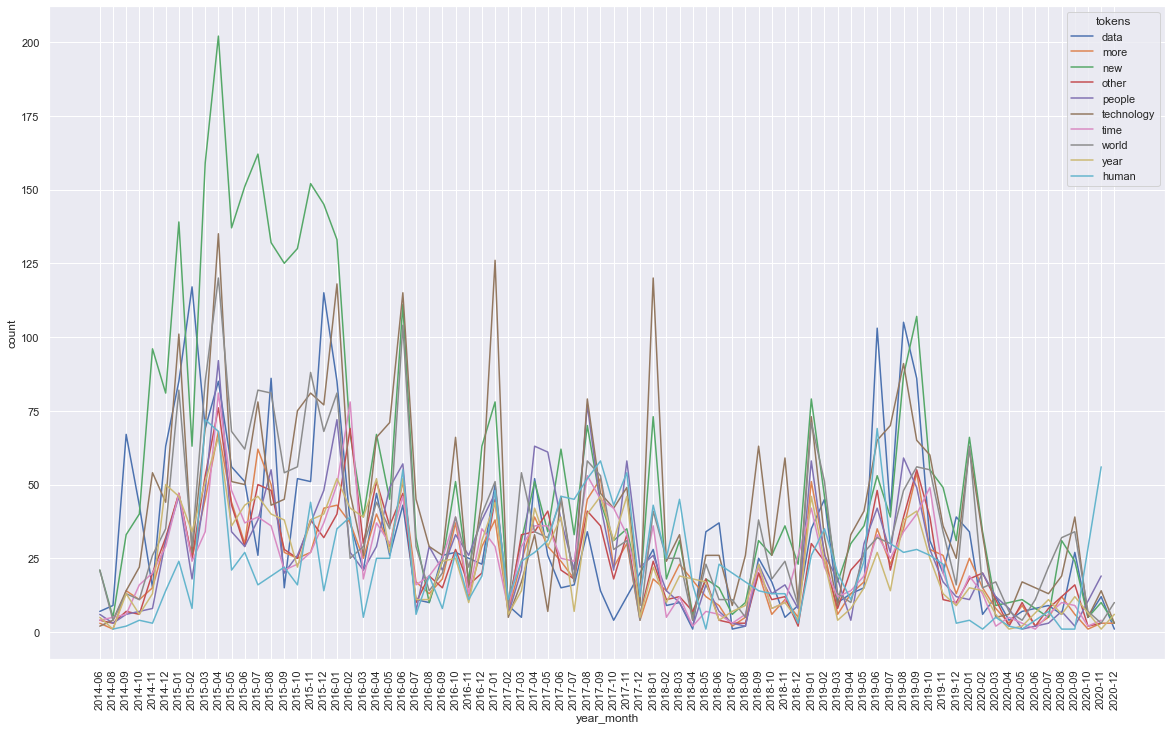

In [181]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(rc={'figure.figsize':(20,12)})

sns.lineplot(data = wef_timecount, x = 'year_month', y = 'count', hue = 'tokens')
plt.xticks(rotation = 90)
plt.show()

## Sentiment

Some language models include sentiment analysis.

`stanza` has a built in "Sentimentprocessor" for performing sentiment analysis on text.

From the documentation: "The `SentimentProcessor` adds a label for sentiment to each `Sentence`. The existing models each support negative, neutral, and positive, represented by 0, 1, 2 respectively" (https://stanfordnlp.github.io/stanza/sentiment.html)

To use it, first define the pipeline to include the sentiment processor (this overwrites the previous pipeline):

In [183]:
nlp = stanza.Pipeline('en', processors='tokenize,sentiment')

2021-01-06 16:28:49 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| sentiment | sstplus |

2021-01-06 16:28:49 INFO: Use device: cpu
2021-01-06 16:28:49 INFO: Loading: tokenize
2021-01-06 16:28:49 INFO: Loading: sentiment
2021-01-06 16:28:50 INFO: Done loading processors!


New pipeline being used on a text in the subset:

In [184]:
doc = nlp(wef_sample.loc[30, 'text'])

Because the processor adds a sentiment label to each sentence, one text will contain several sentiment scores:

In [185]:
for sentence in doc.sentences:
    print(sentence.text + ", " + str(sentence.sentiment))

Many of us feel angry and powerless at the moment., 0
Sickened that our world has been turned upside down by nameless others, whose values we don’t share, who never gave our views, or our lives, a cursory thought., 0
Welcome to the world of Trump and Brexit voters, and many others of all political persuasions in different parts of the world., 1
They have been feeling like this for the last ten years and it’s why they did what they did., 1
The US election has focused attention on issues which are at the heart of social cohesion across the West., 1
We need to get past our own disappointment and fear to think hard about how we use this knowledge to shape the future in a more inclusive and responsive way., 1
Technology is an important part of a complex set of trends driving the Fourth Industrial Revolution, as the digital age creates some jobs, threatens others and changes the way our societies function., 1
Image: World Economic, 1
Forum Future of Jobs report, 1
From my perspective, leadin

To get an idea of the sentiment in a text, a function can be defined to calculate the mean sentiment of the sentences in the text:

In [186]:
def mean_sentiment(text):
    doc = nlp(text)
    
    mean_sentiment = np.mean([sentence.sentiment for sentence in doc.sentences])
    
    return(mean_sentiment)

In [190]:
mean_sentiment(wef_sample.loc[30, 'text'])

1.065217391304348

Using this sentiment analyzer and this way of calculating, this text is considered to be overall neutral. (Calculating the sentiment this way could be critizied. This way of calculating does fx not account for the length of sentences.)

The function can then be used to create a `sentiment` variable using the `.apply()` method in pandas:

In [191]:
wef_sample['sentiment'] = wef_sample['text'].apply(mean_sentiment)

In [192]:
wef_sample.head()

,title,url,publish_date,access_date,links,html,text,tokens,sentiment
0,How is technology transforming logistics? | Wo...,https://www.weforum.org/agenda/2015/04/how-is-...,20 Apr 2015,2020-12-03,[http://global.sap.com/campaigns/digitalhub-in...,"<div class=""article-body legacy-content""><p><s...",We now live in a world where constant connecti...,"[world, constant, connectivity, many, year, in...",0.948718
1,How do we think? | World Economic Forum,https://www.weforum.org/agenda/2017/05/what-s-...,19 May 2017,2020-12-03,[http://www.sciencedirect.com/science/article/...,"<div class=""article-body""><div class=""st__cont...",\nHarvard scientists are beginning to provide ...,"[harvard, scientist, answer, thorniest, questi...",0.918367
2,This planet experiences eclipses that last thr...,https://www.weforum.org/agenda/2016/02/this-pl...,22 Feb 2016,2020-12-03,[http://arxiv.org/abs/1601.00135],"<div class=""article-body""><div class=""st__cont...",\nScientists have discovered a binary star sys...,"[scientist, binary, star, system, light, year,...",1.060606
3,Look no hands: self-driving vehicles' public t...,https://www.weforum.org/agenda/2019/08/self-dr...,12 Aug 2019,2020-12-03,[https://www.reuters.com/subjects/reuters-poll...,"<div class=""article-body""><div class=""st__cont...",\nWhile the Silicon Valley race to make autono...,"[silicon, valley, race, autonomous, vehicle, a...",0.890625
4,No country should close the door on talent | W...,https://www.weforum.org/agenda/2014/06/klaus-s...,23 Jun 2014,2020-12-03,[http://www.nzz.ch/meinung/debatte/talente-suc...,"<div class=""article-body legacy-content""><p>I ...",I have a strict principle not to comment on po...,"[strict, principle, political, matter, democra...",0.916667


We can again visualize the changes in sentiment over time (maybe relevant for a particular subset of texts):

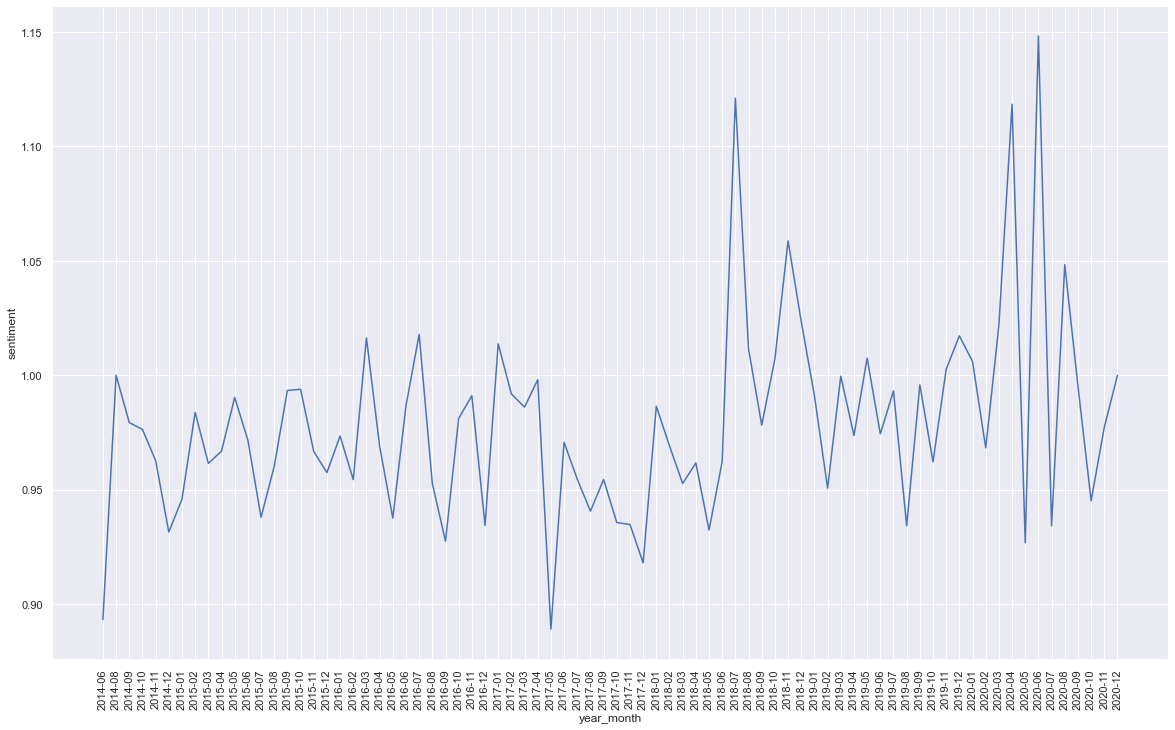

In [195]:
wef_sample['publish_date'] = pd.to_datetime(wef_sample['publish_date']) # This code converts the variable/column to a date variable/column
wef_sample['year_month'] = wef_sample['publish_date'].apply(lambda x: str(x)[0:7])
wef_grouped = wef_sample.groupby('year_month')

wef_sent = wef_grouped['sentiment'].mean().reset_index()

sns.lineplot(data = wef_sent, x = "year_month", y = "sentiment")
plt.xticks(rotation = 90)
plt.show()